# import Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from IPython.display import HTML

### some constants, I will use these constants again and again

In [36]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

# Load Dataset

In [37]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [38]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [39]:
len(dataset)

68

In [40]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 2 1 0 0 0 1 1 0 0 2 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0]


In [41]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[162. 143. 145.]
  [165. 146. 148.]
  [159. 140. 142.]
  ...
  [143. 114. 116.]
  [133. 104. 106.]
  [115.  86.  88.]]

 [[162. 143. 145.]
  [156. 137. 139.]
  [145. 126. 128.]
  ...
  [142. 116. 117.]
  [141. 112. 114.]
  [112.  86.  87.]]

 [[169. 150. 152.]
  [162. 143. 145.]
  [150. 131. 133.]
  ...
  [133. 108. 111.]
  [121.  95.  98.]
  [141. 116. 119.]]

 ...

 [[194. 181. 175.]
  [196. 183. 177.]
  [187. 174. 168.]
  ...
  [151. 130. 127.]
  [138. 117. 114.]
  [135. 114. 111.]]

 [[198. 185. 179.]
  [208. 195. 189.]
  [196. 183. 177.]
  ...
  [166. 145. 142.]
  [137. 116. 113.]
  [156. 135. 132.]]

 [[194. 181. 175.]
  [208. 195. 189.]
  [191. 178. 172.]
  ...
  [103.  82.  79.]
  [162. 141. 138.]
  [122. 101.  98.]]]


# Show some images of dataset

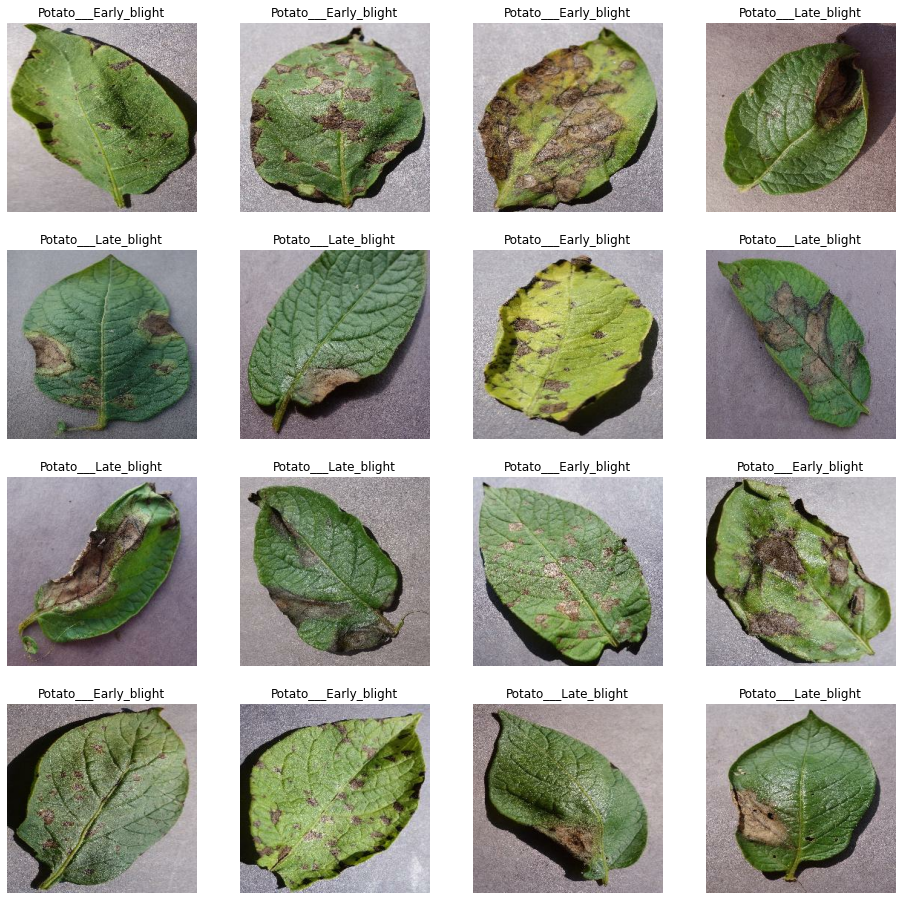

In [42]:
plt.figure(figsize=(16,16))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

# Partition of dataset

In [46]:
def partition(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    train_size = int(train_size*ds_size)
    test_size = int(test_size*ds_size)
    
    train_dataset = ds.take(train_size)
    test_dataset = ds.skip(train_size).take(test_size)
    val_dataset = ds.skip(train_size).skip(test_size)
    
    return train_dataset, test_dataset, val_dataset

In [47]:
train_dataset, test_dataset, val_dataset = partition(dataset)

In [48]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

54
6
8


In [49]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Resize and Rescaling

In [50]:
resizing_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation

In [51]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Building

In [55]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    resizing_rescaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
#    layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=input_shape),
#    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

In [56]:
model.build(input_shape=input_shape)

In [57]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [58]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
    
)

In [59]:
model.fit(
    train_dataset,
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    epochs = EPOCHS,  
)

Epoch 1/20
54/54 [==============================] - 104s 2s/step - loss: 0.8669 - accuracy: 0.5498 - val_loss: 0.6541 - val_accuracy: 0.7371
Epoch 2/20
54/54 [==============================] - 104s 2s/step - loss: 0.5433 - accuracy: 0.7703 - val_loss: 0.5888 - val_accuracy: 0.7672
Epoch 3/20
54/54 [==============================] - 102s 2s/step - loss: 0.3305 - accuracy: 0.8692 - val_loss: 0.3376 - val_accuracy: 0.8707
Epoch 4/20
54/54 [==============================] - 100s 2s/step - loss: 0.2855 - accuracy: 0.8837 - val_loss: 0.2095 - val_accuracy: 0.9009
Epoch 5/20
54/54 [==============================] - 97s 2s/step - loss: 0.1967 - accuracy: 0.9213 - val_loss: 0.2068 - val_accuracy: 0.9138
Epoch 6/20
54/54 [==============================] - 96s 2s/step - loss: 0.2142 - accuracy: 0.9196 - val_loss: 0.1944 - val_accuracy: 0.9353
Epoch 7/20
54/54 [==============================] - 98s 2s/step - loss: 0.1843 - accuracy: 0.9311 - val_loss: 0.2494 - val_accuracy: 0.8879
Epoch 8/20
54/54

In [60]:
scores = model.evaluate(test_dataset)

6/6 [==============================] - 7s 749ms/step - loss: 0.0958 - accuracy: 0.9740


In [61]:
scores

[0.09579026699066162, 0.9739583134651184]

## Run Prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


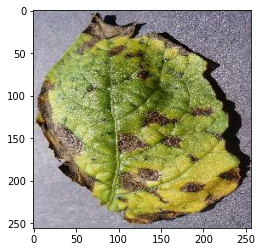

In [63]:

for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

## Prediction for some images with confidence

In [68]:
def prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

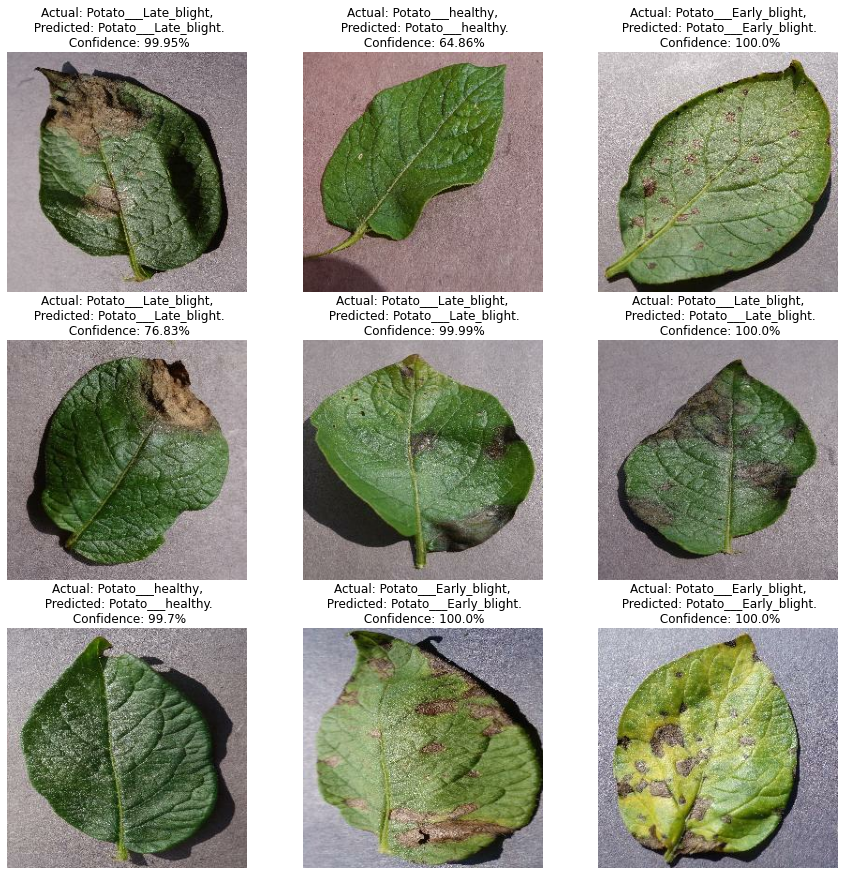

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = prediction(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# saving our model

In [70]:
import os
model_version=max([int(i) for i in os.listdir("../Models") + [0]])+1
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/2\assets
